<a href="https://colab.research.google.com/github/bnsreenu/python_for_microscopists/blob/master/331_fine_tune_SAM_mito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://youtu.be/83tnWs_YBRQ

**This notebook walks you through the process of fine-tuning a Segment Anything Model (SAM) using custom data**.
<p>

**What is SAM?**
<br>
SAM is an image segmentation model developed by Meta AI. It was trained over 11 billion segmentation masks from millions of images. It is designed to take human prompts, in the form of points, bounding boxes or even a text prompt describing what should be segmented.
<p>

**What are the key features of SAM?**
<br>

* **Zero-shot generalization:** SAM can be used to segment objects that it has never seen before, without the need for additional training.

* **Flexible prompting:** SAM can be prompted with a variety of input, including points, boxes, and text descriptions.

* **Real-time mask computation:** SAM can generate masks for objects in real time. This makes SAM ideal for applications where it is necessary to segment objects quickly, such as autonomous driving and robotics.

* **Ambiguity awareness:** SAM is aware of the ambiguity of objects in images. This means that SAM can generate masks for objects even when they are partially occluded or overlapping with other objects.

<p>

**How does SAM work?**
<br>
SAM works by first encoding the image into a high-dimensional vector representation. The prompt is encoded into a separate vector representation. The two vector representations are then combined and passed to a mask decoder, which outputs a mask for the object specified by the prompt.
<p>
The image encoder is a vision transformer (ViT-H) model, which is a large language model that has been pre-trained on a massive dataset of images. The prompt encoder is a simple text encoder that converts the input prompt into a vector representation. The mask decoder is a lightweight transformer model that predicts the object mask from the image and prompt embeddings.
<p>

**SAM paper:** https://arxiv.org/pdf/2304.02643.pdf​
<p>

**Link to the dataset used in this demonstration:** https://www.epfl.ch/labs/cvlab/data/data-em/
<br>Courtesy: EPFL
<p>

This code has been heavily adapted from this notebook but modified to work with a truly custom dataset where we have a bunch of images and binary masks.
https://github.com/NielsRogge/Transformers-Tutorials/blob/master/SAM/Fine_tune_SAM_(segment_anything)_on_a_custom_dataset.ipynb



In [17]:
# Install the required libraries
#SAM
!pip install git+https://github.com/facebookresearch/segment-anything.git
#Transformers
!pip install -q git+https://github.com/huggingface/transformers.git
#Datasets to prepare data and monai if you want to use special loss functions
!pip install datasets
!pip install -q monai
#Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
!pip install patchify

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-sanqjwqo
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-sanqjwqo
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done


In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import tifffile
import os
from patchify import patchify  #Only to handle large images
import random
from scipy import ndimage 
from pycocotools import mask as maskUtils
import yaml
import cv2
import torch


### datastes

In [13]:
from torchvision.datasets import CocoDetection
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from segment_anything import SamPredictor, sam_model_registry
import torchvision.transforms.functional as F
from pycocotools import mask as coco_mask
from patchify import patchify

# Load the COCO dataset
train_dataset = CocoDetection(
    root="/mnt/data/backup_pan/Dataset/Seg-dominik-iphone/Dominik-seg.v4i.coco-segmentation/train",
    annFile="/mnt/data/backup_pan/Dataset/Seg-dominik-iphone/Dominik-seg.v4i.coco-segmentation/train/_annotations.coco.json",
    transform = ToTensor()
)

val_dataset = CocoDetection(
    root="/mnt/data/backup_pan/Dataset/Seg-dominik-iphone/Dominik-seg.v4i.coco-segmentation/valid",
    annFile="/mnt/data/backup_pan/Dataset/Seg-dominik-iphone/Dominik-seg.v4i.coco-segmentation/valid/_annotations.coco.json",
    transform=ToTensor()
)

test_dataset = CocoDetection(
    root="/mnt/data/backup_pan/Dataset/Seg-dominik-iphone/Dominik-seg.v4i.coco-segmentation/test",
    annFile="/mnt/data/backup_pan/Dataset/Seg-dominik-iphone/Dominik-seg.v4i.coco-segmentation/test/_annotations.coco.json",
    transform=ToTensor()
)

batch_size = 1

# Load the data into a DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [17]:
batch_size = 1
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

patch_size = 256 
step = 256 

all_img_patches = []
all_mask_patches = []

for img, targets in train_loader:
    image_np = img.squeeze(0).numpy()  
    height, width = image_np.shape[1], image_np.shape[2]  #
    
    masks = np.zeros((height, width), dtype=np.uint8)
    for target in targets:
        annotation = target['segmentation']
        if isinstance(annotation, list):
            annotation = [[float(point) for point in segment] for segment in annotation] 
            rle = coco_mask.frPyObjects(annotation, height, width)
            mask = coco_mask.decode(rle)
            
            if len(mask.shape) > 2:
                mask = np.amax(mask, axis=2)
            
            masks = np.maximum(masks, mask)
    
    patches_img = patchify(image_np.transpose(1, 2, 0), (patch_size, patch_size, 3), step=step)  # 对图像进行patchify
    patches_mask = patchify(masks, (patch_size, patch_size), step=step)  # 对mask进行patchify

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            single_patch_img = patches_img[i, j, :, :, :]
            single_patch_mask = patches_mask[i, j, :, :]
            all_img_patches.append(single_patch_img)
            all_mask_patches.append(single_patch_mask)

images_np = np.array(all_img_patches)
masks_np = np.array(all_mask_patches)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(images_np[0])
plt.title("Image")
plt.subplot(1, 2, 2)
plt.imshow(masks_np[0], cmap='gray')
plt.title("Mask")
plt.show()


[[tensor([270.6670], dtype=torch.float64), tensor([0]), tensor([269.3330], dtype=torch.float64), tensor([1]), tensor([269.3330], dtype=torch.float64), tensor([7]), tensor([266.6670], dtype=torch.float64), tensor([9]), tensor([266.6670], dtype=torch.float64), tensor([83]), tensor([269.3330], dtype=torch.float64), tensor([85]), tensor([269.3330], dtype=torch.float64), tensor([95]), tensor([266.6670], dtype=torch.float64), tensor([97]), tensor([266.6670], dtype=torch.float64), tensor([99]), tensor([269.3330], dtype=torch.float64), tensor([101]), tensor([269.3330], dtype=torch.float64), tensor([207]), tensor([266.6670], dtype=torch.float64), tensor([209]), tensor([266.6670], dtype=torch.float64), tensor([449]), tensor([264]), tensor([451]), tensor([264]), tensor([503]), tensor([261.3330], dtype=torch.float64), tensor([505]), tensor([261.3330], dtype=torch.float64), tensor([507]), tensor([264]), tensor([509]), tensor([264]), tensor([511]), tensor([261.3330], dtype=torch.float64), tensor([51

ValueError: Buffer has wrong number of dimensions (expected 1, got 2)

## show samples

### image and mask

Image shape: torch.Size([3, 1024, 1024])
Number of targets: 1
Annotations: [{'id': tensor([0]), 'image_id': tensor([0]), 'category_id': tensor([1]), 'bbox': [tensor([259]), tensor([0]), tensor([461.3330], dtype=torch.float64), tensor([1024])], 'area': tensor([472405.3330], dtype=torch.float64), 'segmentation': [[tensor([270.6670], dtype=torch.float64), tensor([0]), tensor([269.3330], dtype=torch.float64), tensor([1]), tensor([269.3330], dtype=torch.float64), tensor([7]), tensor([266.6670], dtype=torch.float64), tensor([9]), tensor([266.6670], dtype=torch.float64), tensor([83]), tensor([269.3330], dtype=torch.float64), tensor([85]), tensor([269.3330], dtype=torch.float64), tensor([95]), tensor([266.6670], dtype=torch.float64), tensor([97]), tensor([266.6670], dtype=torch.float64), tensor([99]), tensor([269.3330], dtype=torch.float64), tensor([101]), tensor([269.3330], dtype=torch.float64), tensor([207]), tensor([266.6670], dtype=torch.float64), tensor([209]), tensor([266.6670], dtype=to

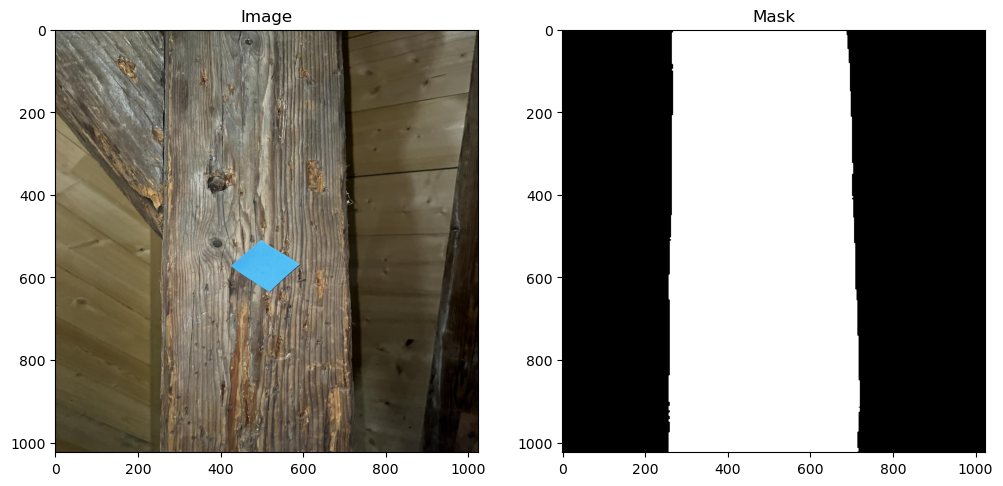

Image shape: torch.Size([3, 1024, 1024])
Number of targets: 1
Annotations: [{'id': tensor([1]), 'image_id': tensor([1]), 'category_id': tensor([1]), 'bbox': [tensor([32]), tensor([0]), tensor([989.3330], dtype=torch.float64), tensor([1024])], 'area': tensor([1013077.3330], dtype=torch.float64), 'segmentation': [[tensor([862.6670], dtype=torch.float64), tensor([0]), tensor([850.6670], dtype=torch.float64), tensor([9]), tensor([850.6670], dtype=torch.float64), tensor([11]), tensor([848]), tensor([13]), tensor([848]), tensor([15]), tensor([842.6670], dtype=torch.float64), tensor([19]), tensor([842.6670], dtype=torch.float64), tensor([21]), tensor([840]), tensor([23]), tensor([837.3330], dtype=torch.float64), tensor([29]), tensor([829.3330], dtype=torch.float64), tensor([35]), tensor([829.3330], dtype=torch.float64), tensor([39]), tensor([824]), tensor([43]), tensor([824]), tensor([47]), tensor([813.3330], dtype=torch.float64), tensor([57]), tensor([813.3330], dtype=torch.float64), tensor(

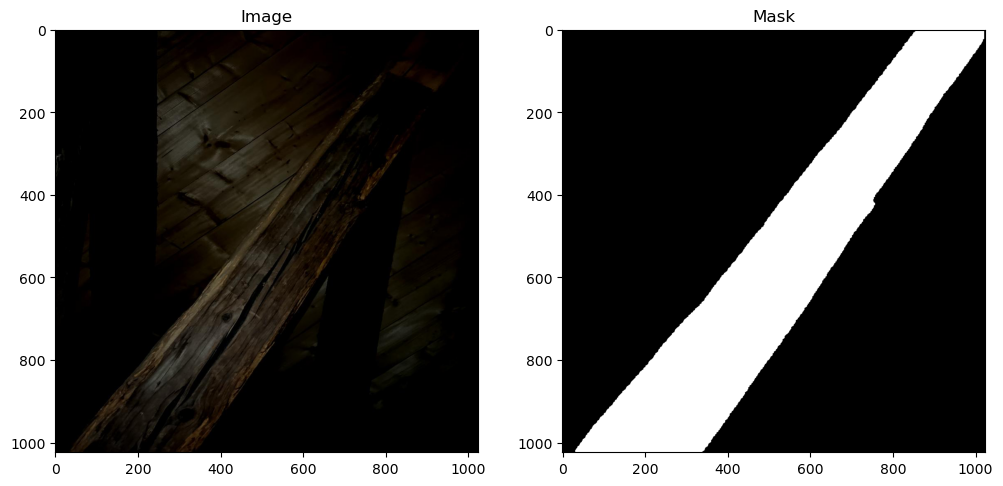

Image shape: torch.Size([3, 1024, 1024])
Number of targets: 5
Annotations: [{'id': tensor([2]), 'image_id': tensor([2]), 'category_id': tensor([1]), 'bbox': [tensor([3]), tensor([0]), tensor([1018.6670], dtype=torch.float64), tensor([1024])], 'area': tensor([1043114.6660], dtype=torch.float64), 'segmentation': [[tensor([6.6670], dtype=torch.float64), tensor([0]), tensor([5.3330], dtype=torch.float64), tensor([1]), tensor([5.3330], dtype=torch.float64), tensor([3]), tensor([2.6670], dtype=torch.float64), tensor([5]), tensor([2.6670], dtype=torch.float64), tensor([73]), tensor([5.3330], dtype=torch.float64), tensor([75]), tensor([5.3330], dtype=torch.float64), tensor([81]), tensor([2.6670], dtype=torch.float64), tensor([83]), tensor([2.6670], dtype=torch.float64), tensor([85]), tensor([5.3330], dtype=torch.float64), tensor([87]), tensor([5.3330], dtype=torch.float64), tensor([95]), tensor([8]), tensor([97]), tensor([8]), tensor([99]), tensor([10.6670], dtype=torch.float64), tensor([101])

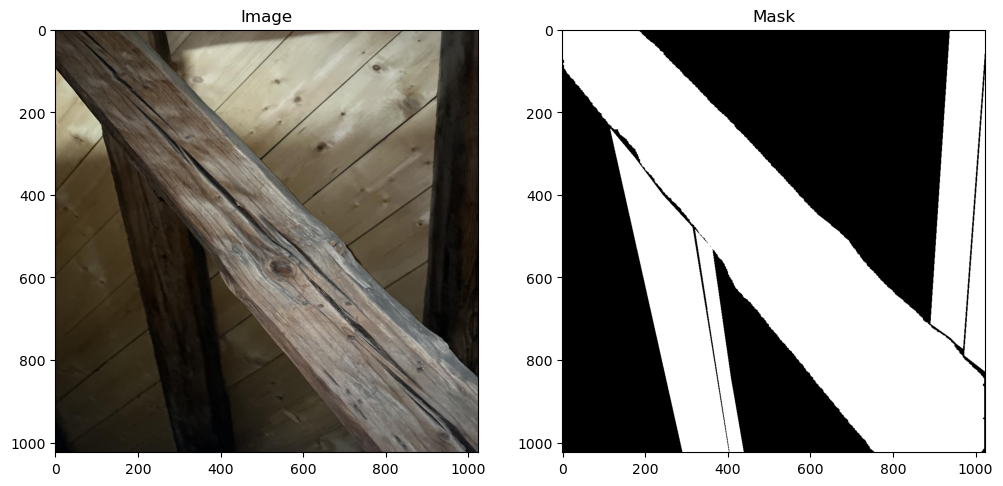

Image shape: torch.Size([3, 1024, 1024])
Number of targets: 3
Annotations: [{'id': tensor([7]), 'image_id': tensor([3]), 'category_id': tensor([1]), 'bbox': [tensor([349]), tensor([0]), tensor([370.6670], dtype=torch.float64), tensor([1024])], 'area': tensor([379562.6670], dtype=torch.float64), 'segmentation': [[tensor([561.3330], dtype=torch.float64), tensor([0]), tensor([560]), tensor([1]), tensor([560]), tensor([57]), tensor([562.6670], dtype=torch.float64), tensor([59]), tensor([562.6670], dtype=torch.float64), tensor([85]), tensor([565.3330], dtype=torch.float64), tensor([87]), tensor([565.3330], dtype=torch.float64), tensor([131]), tensor([568]), tensor([133]), tensor([568]), tensor([149]), tensor([570.6670], dtype=torch.float64), tensor([151]), tensor([570.6670], dtype=torch.float64), tensor([171]), tensor([573.3330], dtype=torch.float64), tensor([173]), tensor([573.3330], dtype=torch.float64), tensor([233]), tensor([570.6670], dtype=torch.float64), tensor([235]), tensor([570.66

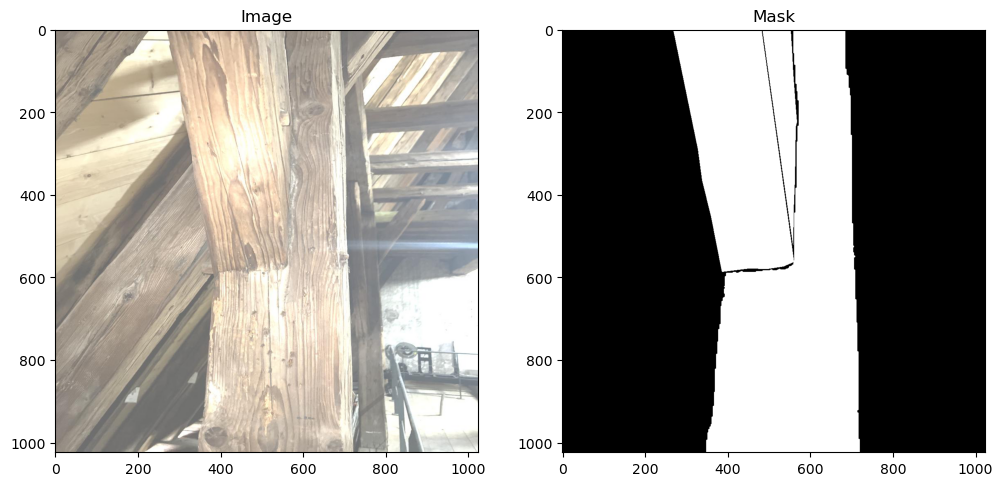

Image shape: torch.Size([3, 1024, 1024])
Number of targets: 8
Annotations: [{'id': tensor([10]), 'image_id': tensor([4]), 'category_id': tensor([1]), 'bbox': [tensor([5]), tensor([0]), tensor([1016]), tensor([1024])], 'area': tensor([1040384]), 'segmentation': [[tensor([6.6670], dtype=torch.float64), tensor([0]), tensor([5.3330], dtype=torch.float64), tensor([1]), tensor([5.3330], dtype=torch.float64), tensor([205]), tensor([10.6670], dtype=torch.float64), tensor([209]), tensor([10.6670], dtype=torch.float64), tensor([213]), tensor([16]), tensor([217]), tensor([16]), tensor([219]), tensor([21.3330], dtype=torch.float64), tensor([223]), tensor([21.3330], dtype=torch.float64), tensor([225]), tensor([24]), tensor([227]), tensor([24]), tensor([229]), tensor([29.3330], dtype=torch.float64), tensor([233]), tensor([29.3330], dtype=torch.float64), tensor([235]), tensor([32]), tensor([237]), tensor([34.6670], dtype=torch.float64), tensor([243]), tensor([40]), tensor([247]), tensor([40]), tensor

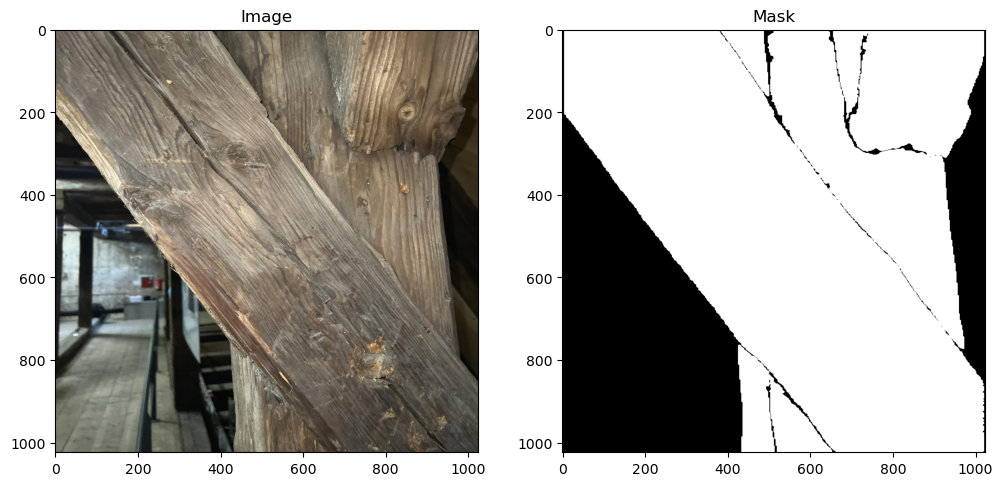

In [7]:
# Function to create a mask from the annotations
def create_mask(image_size, annotations):
    mask = np.zeros(image_size, dtype=np.uint8)
    for ann in annotations:
        if 'segmentation' in ann:
            for seg in ann['segmentation']:
                poly = np.array(seg).reshape((len(seg) // 2, 2))
                cv2.fillPoly(mask, [poly.astype(np.int32)], 1)
    return mask

# Number of images to display
num_images_to_display = 5

# Process the images
for idx, (images, targets) in enumerate(train_loader):
    if idx >= num_images_to_display:
        break

    # Since batch_size=1, we need to access images[0] and targets[0]
    image = images[0]
    target = targets

    print(f"Image shape: {image.shape}")
    print(f"Number of targets: {len(target)}")
    print(f"Annotations: {target}")

    # Convert the image to numpy format
    image_np = np.transpose(image.numpy(), (1, 2, 0))

    # Create a mask from the annotations
    image_size = (image_np.shape[0], image_np.shape[1])
    mask = create_mask(image_size, target)

    # Display the image and mask
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    axs[0].imshow(image_np)
    axs[0].set_title('Image')

    axs[1].imshow(mask, cmap='gray')
    axs[1].set_title('Mask')

    plt.show()
    break


Annotations: {'id': tensor([0]), 'image_id': tensor([0]), 'category_id': tensor([1]), 'bbox': [tensor([259]), tensor([0]), tensor([461.3330], dtype=torch.float64), tensor([1024])], 'area': tensor([472405.3330], dtype=torch.float64), 'segmentation': [[tensor([270.6670], dtype=torch.float64), tensor([0]), tensor([269.3330], dtype=torch.float64), tensor([1]), tensor([269.3330], dtype=torch.float64), tensor([7]), tensor([266.6670], dtype=torch.float64), tensor([9]), tensor([266.6670], dtype=torch.float64), tensor([83]), tensor([269.3330], dtype=torch.float64), tensor([85]), tensor([269.3330], dtype=torch.float64), tensor([95]), tensor([266.6670], dtype=torch.float64), tensor([97]), tensor([266.6670], dtype=torch.float64), tensor([99]), tensor([269.3330], dtype=torch.float64), tensor([101]), tensor([269.3330], dtype=torch.float64), tensor([207]), tensor([266.6670], dtype=torch.float64), tensor([209]), tensor([266.6670], dtype=torch.float64), tensor([449]), tensor([264]), tensor([451]), tens

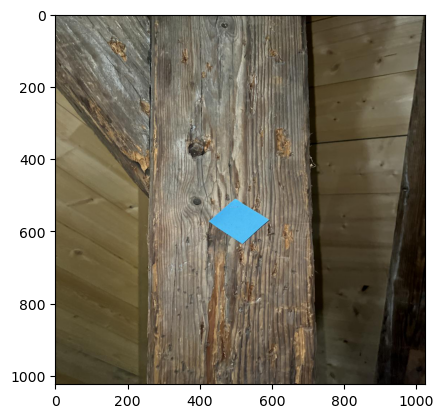

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Function to display an image along with its annotations
def display_image(image, annotation):
    print(f"Image shape: {image.shape}")
    plt.imshow(image.permute(1, 2, 0).numpy())
    
    height, width = image.shape[1], image.shape[2]
    
    if isinstance(annotation, list):
        for ann in annotation:
            if isinstance(ann['segmentation'], list):
                mask = np.zeros((height, width), dtype=np.uint8)
                for seg in ann['segmentation']:
                    # Convert tensor to numpy array and reshape
                    poly = np.array(seg).reshape((-1, 2))
                    poly = poly.astype(np.int32)  # Convert to int32 for cv2.fillPoly
                    cv2.fillPoly(mask, [poly], 1)
            else:
                mask = F.pil_to_tensor(ann['segmentation']).squeeze().numpy()

            print(f"Mask shape: {mask.shape}")
            plt.imshow(mask, alpha=0.5)
    else:
        print("Annotation is not in expected format.")
    
    plt.show()

# Load one batch of data
for images, annotations in train_loader:
    image = images[0]
    annotation = annotations[0]
    print(f"Annotations: {annotation}")  # Print the annotation to check its format
    display_image(image, annotation)
    break


### example detail

In [11]:
example = train_dataset[0]

# The example is a tuple containing (image, target)
image, target = example

print("Image shape:", image.shape)
print("Target:", target)

# Display image and target shapes/details
print("Image tensor shape:", image.shape)
print("Number of targets:", len(target))

for idx, t in enumerate(target):
    print(f"Target {idx}:")
    for key, value in t.items():
        if isinstance(value, list):
            print(f"  {key}: list of length {len(value)}")
        elif isinstance(value, torch.Tensor):
            print(f"  {key}: tensor of shape {value.shape}")
        else:
            print(f"  {key}: {value}")


Image shape: torch.Size([3, 1024, 1024])
Target: [{'id': 0, 'image_id': 0, 'category_id': 1, 'bbox': [259, 0, 461.333, 1024], 'area': 472405.333, 'segmentation': [[270.667, 0, 269.333, 1, 269.333, 7, 266.667, 9, 266.667, 83, 269.333, 85, 269.333, 95, 266.667, 97, 266.667, 99, 269.333, 101, 269.333, 207, 266.667, 209, 266.667, 449, 264, 451, 264, 503, 261.333, 505, 261.333, 507, 264, 509, 264, 511, 261.333, 513, 261.333, 593, 258.667, 595, 258.667, 653, 261.333, 655, 261.333, 837, 258.667, 839, 258.667, 901, 261.333, 903, 261.333, 911, 258.667, 913, 258.667, 921, 261.333, 923, 261.333, 927, 258.667, 929, 258.667, 935, 261.333, 937, 261.333, 943, 258.667, 945, 258.667, 949, 261.333, 951, 261.333, 975, 258.667, 977, 258.667, 1023, 260, 1024, 713.333, 1024, 717.333, 1021, 717.333, 1015, 714.667, 1013, 714.667, 975, 717.333, 973, 717.333, 927, 720, 925, 720, 917, 717.333, 915, 720, 913, 720, 851, 717.333, 849, 717.333, 743, 714.667, 741, 714.667, 657, 712, 655, 712, 631, 709.333, 629, 709.3

## model

In [5]:
# Checkpoint path
checkpoint_path = "sam_vit_b_01ec64.pth"
assert os.path.isfile(checkpoint_path), f"File {checkpoint_path} does not exist or is not a file."

# Load the SAM model
device = "cuda" if torch.cuda.is_available() else "cpu"
sam = sam_model_registry["vit_b"](checkpoint=checkpoint_path).to(device)
predictor = SamPredictor(sam)

#### freze vision encoder, prompt encoder and image encoder

In [6]:


# Make sure we only compute gradients for mask decoder
for name, param in sam.named_parameters():
    if name.startswith("vision_encoder") or name.startswith("prompt_encoder") or name.startswith("image_encoder"):
        param.requires_grad = False  # Correct way to set requires_grad

# Verify which parameters will be trained
for name, param in sam.named_parameters():
    if param.requires_grad:
        print(f"Parameter {name} will be trained.")
    else:
        print(f"Parameter {name} will be frozen.")


# # Ensure all parameters require gradients
# for param in sam.parameters():
#     param.requires_grad = True



Parameter image_encoder.pos_embed will be frozen.
Parameter image_encoder.patch_embed.proj.weight will be frozen.
Parameter image_encoder.patch_embed.proj.bias will be frozen.
Parameter image_encoder.blocks.0.norm1.weight will be frozen.
Parameter image_encoder.blocks.0.norm1.bias will be frozen.
Parameter image_encoder.blocks.0.attn.rel_pos_h will be frozen.
Parameter image_encoder.blocks.0.attn.rel_pos_w will be frozen.
Parameter image_encoder.blocks.0.attn.qkv.weight will be frozen.
Parameter image_encoder.blocks.0.attn.qkv.bias will be frozen.
Parameter image_encoder.blocks.0.attn.proj.weight will be frozen.
Parameter image_encoder.blocks.0.attn.proj.bias will be frozen.
Parameter image_encoder.blocks.0.norm2.weight will be frozen.
Parameter image_encoder.blocks.0.norm2.bias will be frozen.
Parameter image_encoder.blocks.0.mlp.lin1.weight will be frozen.
Parameter image_encoder.blocks.0.mlp.lin1.bias will be frozen.
Parameter image_encoder.blocks.0.mlp.lin2.weight will be frozen.
P

### check sam architecture

In [14]:
# print(sam)


Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


### define hyperparemeter

In [7]:
project_name = "SAM"
task_name = "SAM_04_0611"

output_dir = rf"/home/jpan/xAI_Masterthesis_Pan/Code/Segmentation/SAM/202406_SegmentAnything/{task_name}"
os.makedirs(output_dir, exist_ok=True)

num_classes = 2 
num_epochs = 10
lr = 1e-4

# Save training configuration to YAML file
config = {
    'project_name': project_name,
    'task_name': task_name,
    'num_classes': num_classes,
    'num_epochs': num_epochs,
    'learning_rate': lr,
    'batch_size': batch_size,
    'checkpoint_path': checkpoint_path,
}


config_path = os.path.join(output_dir, 'config.yaml')
with open(config_path, 'w') as file:
    yaml.dump(config, file)

# Loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(sam.mask_decoder.parameters(), lr=lr, weight_decay=0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sam.to(device)

def get_bounding_box(target):
    bbox = target['bbox']
    bbox = [float(val) for val in bbox]
    bbox = np.array(bbox).reshape(1, 4)
    return bbox

def get_segmentation_mask(target, image_size):
    segmentation = target['segmentation']
    
    # Ensure segmentation is a list of lists of tensors
    if not isinstance(segmentation, list) or not all(isinstance(poly, list) for poly in segmentation):
        raise ValueError(f"Invalid segmentation format: {segmentation}")

    # Convert tensors to lists
    segmentation = [[float(coord) for coord in poly] for poly in segmentation]

    rle = maskUtils.frPyObjects(segmentation, image_size[0], image_size[1])
    mask = maskUtils.decode(rle)
    if len(mask.shape) == 3:
        mask = np.any(mask, axis=2).astype(np.uint8)
    return torch.tensor(mask, dtype=torch.long)

def get_image_info(dataset, index):
    """Get image info such as file name"""
    image_id = dataset.ids[index]
    img_info = dataset.coco.loadImgs(image_id)[0]
    return img_info['file_name']

def get_annotation_info(dataset, target):
    """Get annotation info such as annotation id or name"""
    ann_id = target['id']
    return f"Annotation ID: {ann_id}"



### clearml monitor

In [8]:
#clearml mac
# %env CLEARML_WEB_HOST=https://app.clear.ml
# %env CLEARML_API_HOST=https://api.clear.ml
# %env CLEARML_FILES_HOST=https://files.clear.ml
# %env CLEARML_API_ACCESS_KEY=QO1VBBX9J2S2VYILQTGI
# %env CLEARML_API_SECRET_KEY=ERuc1S6o5SirQGugvYXDFjH9b9aNi0u8S3rpALzXMa8YPSLDMW

# clearml win
%env CLEARML_WEB_HOST=https://app.clear.ml
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=Z4YDBU13VPOFHBHF8667
%env CLEARML_API_SECRET_KEY=JMzvRXn76AT83WuFJfS0FBGCY8c5TccbH5XboTYztrWqwzDdyn

from clearml import Task

#Clear ML Initialization
cl_task = Task.init(project_name=project_name,task_name=task_name)
logger = cl_task.get_logger()

env: CLEARML_WEB_HOST=https://app.clear.ml
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml
env: CLEARML_API_ACCESS_KEY=Z4YDBU13VPOFHBHF8667
env: CLEARML_API_SECRET_KEY=JMzvRXn76AT83WuFJfS0FBGCY8c5TccbH5XboTYztrWqwzDdyn
ClearML Task: created new task id=37d6194d82e04557a81e795fa9acbf88
2024-06-11 11:58:34,750 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/3230392d1db54f0d87f52243e729d3b8/experiments/37d6194d82e04557a81e795fa9acbf88/output/log


ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring
ClearML Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start


### train

In [12]:
import torch
import numpy as np
from tqdm import tqdm
from PIL import Image
from torchvision.transforms.functional import to_pil_image
import torch.nn.functional as F

# Lists to store loss values
train_losses = []
val_losses = []


# Training code
sam.train()

for epoch in range(num_epochs):
    sam.train()
    train_loss = 0
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
    
    for batch_idx, (images, targets) in enumerate(train_loader_tqdm):
        image = images[0].requires_grad_()
        image = to_pil_image(image)
        image = np.array(image)

        # Print the image name at the start of each batch
        image_name = get_image_info(train_dataset, batch_idx)
        train_loader_tqdm.set_postfix_str(f"Processing image in train: {image_name}")

        for target in targets:  # Loop over all targets in the current image
            bboxes = get_bounding_box(target)

            for bbox in bboxes:
                x_min, y_min, width, height = bbox
                x_max = x_min + width
                y_max = y_min + height
                input_bbox = np.array([x_min, y_min, x_max, y_max])

                predictor.set_image(image)
                masks, _, _ = predictor.predict(box=input_bbox, point_coords=None, point_labels=None, multimask_output=False)

                # Convert masks to tensor and ensure it's a float tensor
                masks = torch.tensor(masks, dtype=torch.float32).squeeze(0)

                # Create num_classes channels for masks
                masks = torch.nn.functional.one_hot(masks.to(torch.int64), num_classes=num_classes).permute(2, 0, 1).float()
                masks.requires_grad_()  # Ensure masks require grad
                target_mask = get_segmentation_mask(target, image.shape[:2])

                # Ensure masks and target_mask are the same shape
                if masks.shape[1:] != target_mask.shape:
                    masks = F.resize(masks, target_mask.shape)

                # Print annotation info and shapes inside the loop
                annotation_info = get_annotation_info(train_dataset, target)
                # print(f"train {annotation_info}, masks shape: {masks.shape}, dtype: {masks.dtype}")
                # print(f"train target_mask shape: {target_mask.shape}, dtype: {target_mask.dtype}")

                # Expand target_mask to match masks shape for criterion
                target_mask = target_mask.unsqueeze(0)

                loss = criterion(masks.unsqueeze(0), target_mask)

                # Backpropagation and optimizing
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                train_loader_tqdm.set_postfix(train_loss=train_loss/(batch_idx+1))

    train_loader_tqdm.close()
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

    # Validation
    sam.eval()
    val_loss = 0
    val_loader_tqdm = tqdm(val_loader, desc=f"Validation {epoch+1}/{num_epochs}", unit="batch")
    
    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(val_loader_tqdm):
            image = images[0]
            image = to_pil_image(image)
            image = np.array(image)

            # Print the image name at the start of each batch
            image_name = get_image_info(val_dataset, batch_idx)
            val_loader_tqdm.set_postfix_str(f"Processing image in valid: {image_name}")

            for target in targets:  # Loop over all targets in the current image
                bboxes = get_bounding_box(target)

                for bbox in bboxes:
                    x_min, y_min, width, height = bbox
                    x_max = x_min + width
                    y_max = y_min + height
                    input_bbox = np.array([x_min, y_min, x_max, y_max])

                    predictor.set_image(image)
                    masks, _, _ = predictor.predict(box=input_bbox, point_coords=None, point_labels=None, multimask_output=False)

                    # Convert masks to tensor and ensure it's a float tensor
                    masks = torch.tensor(masks, dtype=torch.float32).squeeze(0)

                    # Create num_classes channels for masks
                    masks = torch.nn.functional.one_hot(masks.to(torch.int64), num_classes=num_classes).permute(2, 0, 1).float()
                    target_mask = get_segmentation_mask(target, image.shape[:2])

                    # Ensure masks and target_mask are the same shape
                    if masks.shape[1:] != target_mask.shape:
                        masks = F.resize(masks, target_mask.shape)

                    # Print annotation info and shapes inside the loop
                    annotation_info = get_annotation_info(val_dataset, target)
                    # print(f"val {annotation_info}, masks shape: {masks.shape}, dtype: {masks.dtype}")
                    # print(f"val target_mask shape: {target_mask.shape}, dtype: {target_mask.dtype}")

                    # Expand target_mask to match masks shape for criterion
                    target_mask = target_mask.unsqueeze(0)

                    loss = criterion(masks.unsqueeze(0), target_mask)
                    val_loss += loss.item()
                    val_loader_tqdm.set_postfix(val_loss=val_loss/(batch_idx+1))

    val_loader_tqdm.close()
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {avg_val_loss:.4f}")

print("Finished Fine-tuning")

# Save the model
model_save_path = os.path.join(output_dir, f"{task_name}.pth")
torch.save(sam.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Save the plot
plot_save_path = os.path.join(output_dir, f"{task_name}_loss_plot.png")
plt.savefig(plot_save_path)
print(f"Loss plot saved to {plot_save_path}")
plt.show()

cl_task.close()


Epoch 1/10:   1%|          | 8/1113 [00:05<12:53,  1.43batch/s, train_loss=1.23]                                                                      

Epoch 1/10: 100%|██████████| 1113/1113 [13:30<00:00,  1.37batch/s, train_loss=1.46]                                                                      


Epoch [1/10], Train Loss: 1.4620


Validation 1/10: 100%|██████████| 107/107 [01:05<00:00,  1.64batch/s, val_loss=1.25]                                                                        


Epoch [1/10], Val Loss: 1.2484


Epoch 2/10: 100%|██████████| 1113/1113 [13:12<00:00,  1.40batch/s, train_loss=1.46]                                                                      


Epoch [2/10], Train Loss: 1.4620


Validation 2/10: 100%|██████████| 107/107 [01:04<00:00,  1.65batch/s, val_loss=1.25]                                                                        


Epoch [2/10], Val Loss: 1.2484


Epoch 3/10: 100%|██████████| 1113/1113 [13:12<00:00,  1.40batch/s, train_loss=1.46]                                                                      


Epoch [3/10], Train Loss: 1.4620


Validation 3/10: 100%|██████████| 107/107 [01:04<00:00,  1.65batch/s, val_loss=1.25]                                                                        


Epoch [3/10], Val Loss: 1.2484


Epoch 4/10: 100%|██████████| 1113/1113 [13:11<00:00,  1.41batch/s, train_loss=1.46]                                                                      


Epoch [4/10], Train Loss: 1.4620


Validation 4/10: 100%|██████████| 107/107 [01:04<00:00,  1.65batch/s, val_loss=1.25]                                                                        


Epoch [4/10], Val Loss: 1.2484


Epoch 5/10: 100%|██████████| 1113/1113 [13:13<00:00,  1.40batch/s, train_loss=1.46]                                                                      


Epoch [5/10], Train Loss: 1.4620


Validation 5/10: 100%|██████████| 107/107 [01:05<00:00,  1.64batch/s, val_loss=1.25]                                                                        


Epoch [5/10], Val Loss: 1.2484


Epoch 6/10: 100%|██████████| 1113/1113 [13:14<00:00,  1.40batch/s, train_loss=1.46]                                                                      


Epoch [6/10], Train Loss: 1.4620


Validation 6/10: 100%|██████████| 107/107 [01:05<00:00,  1.64batch/s, val_loss=1.25]                                                                        


Epoch [6/10], Val Loss: 1.2484


Epoch 7/10: 100%|██████████| 1113/1113 [13:11<00:00,  1.41batch/s, train_loss=1.46]                                                                      


Epoch [7/10], Train Loss: 1.4620


Validation 7/10: 100%|██████████| 107/107 [01:04<00:00,  1.65batch/s, val_loss=1.25]                                                                        


Epoch [7/10], Val Loss: 1.2484


Epoch 8/10: 100%|██████████| 1113/1113 [13:13<00:00,  1.40batch/s, train_loss=1.46]                                                                      


Epoch [8/10], Train Loss: 1.4620


Validation 8/10: 100%|██████████| 107/107 [01:04<00:00,  1.65batch/s, val_loss=1.25]                                                                        


Epoch [8/10], Val Loss: 1.2484


Epoch 9/10:  49%|████▊     | 542/1113 [06:28<06:49,  1.40batch/s, train_loss=1.47]                                                                      


KeyboardInterrupt: 

In [10]:
# import torch
# import numpy as np
from tqdm import tqdm
# from PIL import Image
# import torchvision.transforms as transforms
# import torch.nn.functional as F

# Training code
sam.train()

for epoch in range(num_epochs):
    sam.train()
    train_loss = 0
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
    
    for batch_idx, (images, targets) in enumerate(train_loader_tqdm):
        image = images[0].requires_grad_()
        image = F.to_pil_image(image)
        image = np.array(image)

        # Print the image name at the start of each batch
        image_name = get_image_info(train_dataset, batch_idx)
        train_loader_tqdm.set_postfix_str(f"Processing image in train: {image_name}")

        for target in targets:  # Loop over all targets in the current image
            bboxes = get_bounding_box(target)

            for bbox in bboxes:
                x_min, y_min, width, height = bbox
                x_max = x_min + width
                y_max = y_min + height
                input_bbox = np.array([x_min, y_min, x_max, y_max])

                predictor.set_image(image)
                masks, _, _ = predictor.predict(box=input_bbox, point_coords=None, point_labels=None, multimask_output=False)

                # Convert masks to tensor and ensure it's a float tensor
                masks = torch.tensor(masks, dtype=torch.float32).squeeze(0)

                # Create num_classes channels for masks
                masks = torch.nn.functional.one_hot(masks.to(torch.int64), num_classes=num_classes).permute(2, 0, 1).float()
                masks.requires_grad_()  # Ensure masks require grad
                target_mask = get_segmentation_mask(target, image.shape[:2])

                # Ensure masks and target_mask are the same shape
                if masks.shape[1:] != target_mask.shape:
                    masks = F.resize(masks, target_mask.shape)

                # Print annotation info and shapes inside the loop
                annotation_info = get_annotation_info(train_dataset, target)
                # print(f"train {annotation_info}, masks shape: {masks.shape}, dtype: {masks.dtype}")
                # print(f"train target_mask shape: {target_mask.shape}, dtype: {target_mask.dtype}")

                # Expand target_mask to match masks shape for criterion
                target_mask = target_mask.unsqueeze(0)

                loss = criterion(masks.unsqueeze(0), target_mask)

                # Backpropagation and optimizing
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                train_loader_tqdm.set_postfix(train_loss=train_loss/(batch_idx+1))

    train_loader_tqdm.close()
    avg_train_loss = train_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

    # Validation
    sam.eval()
    val_loss = 0
    val_loader_tqdm = tqdm(val_loader, desc=f"Validation {epoch+1}/{num_epochs}", unit="batch")
    
    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(val_loader_tqdm):
            image = images[0]
            image = F.to_pil_image(image)
            image = np.array(image)

            # Print the image name at the start of each batch
            image_name = get_image_info(val_dataset, batch_idx)
            val_loader_tqdm.set_postfix_str(f"Processing image in valid: {image_name}")

            for target in targets:  # Loop over all targets in the current image
                bboxes = get_bounding_box(target)

                for bbox in bboxes:
                    x_min, y_min, width, height = bbox
                    x_max = x_min + width
                    y_max = y_min + height
                    input_bbox = np.array([x_min, y_min, x_max, y_max])

                    predictor.set_image(image)
                    masks, _, _ = predictor.predict(box=input_bbox, point_coords=None, point_labels=None, multimask_output=False)

                    # Convert masks to tensor and ensure it's a float tensor
                    masks = torch.tensor(masks, dtype=torch.float32).squeeze(0)

                    # Create num_classes channels for masks
                    masks = torch.nn.functional.one_hot(masks.to(torch.int64), num_classes=num_classes).permute(2, 0, 1).float()
                    target_mask = get_segmentation_mask(target, image.shape[:2])

                    # Ensure masks and target_mask are the same shape
                    if masks.shape[1:] != target_mask.shape:
                        masks = F.resize(masks, target_mask.shape)

                    # Print annotation info and shapes inside the loop
                    annotation_info = get_annotation_info(val_dataset, target)
                    # print(f"val {annotation_info}, masks shape: {masks.shape}, dtype: {masks.dtype}")
                    # print(f"val target_mask shape: {target_mask.shape}, dtype: {target_mask.dtype}")

                    # Expand target_mask to match masks shape for criterion
                    target_mask = target_mask.unsqueeze(0)

                    loss = criterion(masks.unsqueeze(0), target_mask)
                    val_loss += loss.item()
                    val_loader_tqdm.set_postfix(val_loss=val_loss/(batch_idx+1))

    val_loader_tqdm.close()
    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {avg_val_loss:.4f}")

print("Finished Fine-tuning")

# Save the model
model_save_path = os.path.join(output_dir, f"{task_name}.pth")
torch.save(sam.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

cl_task.close()


Epoch 1/10:   0%|          | 0/1113 [00:00<?, ?batch/s]

Epoch 1/10:   0%|          | 0/1113 [00:00<?, ?batch/s]


AttributeError: module 'torch.nn.functional' has no attribute 'to_pil_image'

In [24]:
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry

model_save_path = "/home/jpan/xAI_Masterthesis_Pan/Code/Segmentation/SAM/202406_SegmentAnything/SAM_02_0609/SAM_02_0609.pth"

device = "cuda" if torch.cuda.is_available() else "cpu"
sam_test = sam_model_registry["vit_b"](checkpoint=model_save_path).to(device)
print("sam_test")

test_image = "/mnt/data/backup_pan/Dataset/Seg-dominik-iphone/Dominik-seg.v4i.coco-segmentation/test/Model_3_0020_jpeg.rf.b1ada19a12423f765881f57d7f2223d6.jpg"

mask_generator = SamAutomaticMaskGenerator(sam_test)
masks = mask_generator.generate(test_image)

sam_test


AttributeError: 'str' object has no attribute 'shape'

In [ ]:
import

def run_inference_on_custom_image(image_path, output_dir, predictor, val_metadata):
    im = cv2.imread(image_path)
    outputs = predictor(im)
    
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW  
    )
    
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis('off')
    
    original_file_name = os.path.basename(image_path)
    new_file_name = f"test_{original_file_name}"
    output_file_path = os.path.join(output_dir, new_file_name)
    plt.savefig(output_file_path, bbox_inches='tight', pad_inches=0)
    # plt.close() 

custom_image_path = "/mnt/data/backup_pan/Dataset/Seg-dominik-iphone/Dominik-seg.v4i.coco-segmentation/test/Model_3_0020_jpeg.rf.b1ada19a12423f765881f57d7f2223d6.jpg" 
output_dir = cfg.OUTPUT_DIR
run_inference_on_custom_image(custom_image_path, output_dir, predictor, val_metadata)
